# Load libraries

In [260]:
%matplotlib inline

import os
import math

import configparser

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import sys
sys.path.append('../..')

from scripps.utils import read_datasets, norm1d, bayesian_linear_regression

import seaborn as sns

In [261]:
CF = read_datasets.get_configuration()
cs_annotator_names = [key for key in dict(CF.items('m2c_citizen_disease')).keys() if key!='path']
cs_annotator_names.sort()
annotator_names = cs_annotator_names # + ['NER_expert']

# Load "expert" annotations

In [262]:
def read_expert_disease_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_expert_disease', 'file')
    anno = anno[[0, 2]]
    anno[2].replace(['I-Disease', 'O', 'B-Disease', 'U-Disease', 'L-Disease'], [1, 0, 1, 1, 1], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[2].rename('NER_expert')], axis=1)
    return annotations

def read_expert_phenotype_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_expert_phenotype', 'file')
    anno = anno[[0, 2]]
    anno[2].replace(['I-phenotype', 'O', 'B-phenotype', 'L-phenotype', 'U-phenotype'], [1, 0, 1, 1, 1], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[2].rename('NER_expert')], axis=1)
    return annotations

def read_expert_mixed_annotations(disease_annotations, phenotype_annotations):
    mixed = [disease_annotations['NER_expert'] == 1][0].replace([True, False], [1, 0]) + \
    [phenotype_annotations['NER_expert'] == 1][0].replace([True, False], [2, 0])
    mixed_annotations = pd.DataFrame()
    mixed_annotations = pd.concat([mixed_annotations, disease_annotations['Token']], axis=1)
    mixed_annotations = pd.concat([mixed_annotations, mixed.replace([0, 1, 2, 3], ['O', 'I-Disease', 'I-Phenotype', 'I-Disease_Pheno'])], axis=1)
    return mixed_annotations
    

In [263]:
expert_disease_annotations = read_expert_disease_annotations()
expert_phenotype_annotations = read_expert_phenotype_annotations()
expert_annotations = read_expert_mixed_annotations(expert_disease_annotations, expert_phenotype_annotations)

# Load all mark2cure citizen scientist annotations

In [264]:
CF = read_datasets.get_configuration()

def read_disease_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c_citizen_disease', anno_name)
        anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

def read_phenotype_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c_citizen_phenotype', anno_name)
        anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

# Load original annotations

In [265]:
def read_both_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c', anno_name)
        anno[3].replace(['I-?', 'I-Disease_Phen', 'I-Gene'], ['O', 'I-Disease_Pheno', 'O'], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

def sanity_check(annotations, columns, values):
    for col in columns:
        assert set(annotations[col].unique()) == set(values)


In [266]:
disease_annotations = read_disease_annotations()
phenotype_annotations = read_phenotype_annotations()

In [267]:
mixed_annotations = read_both_annotations()
sanity_check(mixed_annotations, cs_annotator_names, ['I-Disease', 'I-Phenotype', 'I-Disease_Pheno', 'O'])

In [268]:
'''
mixed_annotations = pd.concat([mixed_annotations, expert_annotations['NER_expert']], axis=1)
disease_annotations = pd.concat([disease_annotations, expert_disease_annotations['NER_expert']], axis=1)
phenotype_annotations = pd.concat([phenotype_annotations, expert_phenotype_annotations['NER_expert']], axis=1)
'''

"\nmixed_annotations = pd.concat([mixed_annotations, expert_annotations['NER_expert']], axis=1)\ndisease_annotations = pd.concat([disease_annotations, expert_disease_annotations['NER_expert']], axis=1)\nphenotype_annotations = pd.concat([phenotype_annotations, expert_phenotype_annotations['NER_expert']], axis=1)\n"

In [269]:
mixed_annotations

,Token,files1,files2,files3,files4,files5,files6
0,Haematuria,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Disease_Pheno,I-Disease_Pheno
1,and,O,O,O,O,O,O
2,abdominal,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,I-Disease
3,aortic,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,I-Disease
4,aneurysm,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,I-Disease
5,.,O,O,O,O,O,O
6,Haematuria,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Disease_Pheno,I-Disease_Pheno
7,and,O,O,O,O,O,O
8,left,I-Phenotype,I-Phenotype,O,O,I-Phenotype,I-Disease_Pheno
9,loin,I-Phenotype,I-Phenotype,O,I-Phenotype,I-Phenotype,I-Disease_Pheno


# Filter relevant rows

In [270]:
def get_relevant_rows(annotations):
    relevant = annotations[annotator_names] != 'O'
    relevant = annotations[relevant.all(axis=1)]
    #relevant = annotations[~(annotations[['Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5']] == 'O').all(axis=1)]
    return relevant

In [271]:
relevant_annotations = get_relevant_rows(mixed_annotations)

In [272]:
disease_annotations = disease_annotations.iloc[relevant_annotations.index]
phenotype_annotations = phenotype_annotations.iloc[relevant_annotations.index]

In [273]:
#disease_annotations = disease_annotations.reset_index()
#phenotype_annotations = phenotype_annotations.reset_index()

# Initialize latent variables

In [274]:
K = disease_annotations.shape[0]
J = disease_annotations.shape[1] - 1

latent = {}

latent['theta'] = np.zeros(K)
latent['d_alpha'] = np.zeros(J)
latent['d_beta'] = np.zeros(J)
latent['d_z'] = np.zeros((K, J))

latent['p_alpha'] = np.zeros(J)
latent['p_beta'] = np.zeros(J)
latent['p_z'] = np.zeros((K, J))

#Should these be separate for disease and phenotype?
latent['b0'] = np.zeros(2)
latent['B0_scale'] = 1
latent['m0'] = np.zeros(K) #TODO: ask HS regarding changing certain values here.
latent['C0_scale'] = 1

latent['K'] = K
latent['J'] = J

# Define functions for resampling using Gibbs sampling

In [275]:
def __get_alpha_beta_z(mode):
    if mode == 'disease':
        alpha = latent['d_alpha']
        beta = latent['d_beta']
        z = latent['d_z']
    else:
        alpha = latent['p_alpha']
        beta = latent['p_beta']
        z = latent['p_z']
    return alpha, beta, z
    

In [276]:
def __resample_z(alpha, beta, z, annotations):
    interval = [-100, 100] #Should this be changed?
    for k in range(K):
    #for k in annotations.index:
        for j in range(J):
            mean = alpha[j] + beta[j]*latent['theta'][k]
            std_dev = 1
            '''
            if(annotations['Annotator{}'.format(j+1)][k] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations['Annotator{}'.format(j+1)][k] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
            '''
            if(annotations[annotator_names[j]][annotations.index[k]] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations[annotator_names[j]][annotations.index[k]] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
    
def resample_z(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    if mode == 'disease':
        annotations = disease_annotations
    else:
        annotations = phenotype_annotations
    __resample_z(alpha, beta, z, annotations)

In [277]:
def __resample_alpha_beta(alpha, beta, z):
    for j in range(J):
        Y = z[:, j]
        X = np.vstack((np.ones(K), latent['theta'])).T
        
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['b0'], latent['B0_scale'], 1)
        sample = np.random.multivariate_normal(WN, VN)
        alpha[j] = sample[0]
        beta[j] = sample[1]

def resample_alpha_beta(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    __resample_alpha_beta(alpha, beta, z)

In [278]:
def resample_theta():
    for k in range(K):
        #Y = latent['d_z'][k, :] - latent['d_alpha'] + latent['p_z'][k, :] - latent['p_alpha']
        #X = latent['d_beta'] + latent['p_beta']
        Y = np.concatenate(((latent['d_z'][k, :] - latent['d_alpha']), (latent['p_z'][k, :] - latent['p_alpha'])), axis=0)
        X = np.concatenate((latent['d_beta'], latent['p_beta']), axis=0)
        X = np.reshape(X, (-1, 1))
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['m0'][k], latent['C0_scale'], 1)
        latent['theta'][k] = np.random.normal(WN, math.sqrt(VN))

In [279]:
def save_latent_variables():
    #TODO: save to csv.
    pass


def resample():
    resample_z('disease')
    resample_z('phenotype')
    resample_theta()
    resample_alpha_beta('disease')
    resample_alpha_beta('phenotype')
    
    save_latent_variables()
    
def has_converged():
    #TODO
    pass
    
def run_sampling(num_iter, thresh, print_freq=50):
    thetas = []
    d_alphas = []
    d_betas = []
    p_alphas = []
    p_betas = []
    for it in xrange(1, num_iter+1):
        resample()
        if it%print_freq == 0:
            print 'Iter {}/{} done.'.format(it, num_iter)
        if has_converged():
            break
        if it > thresh:
            thetas.append(np.array(latent['theta']))
            d_alphas.append(np.array(latent['d_alpha']))
            p_alphas.append(np.array(latent['p_alpha']))
            d_betas.append(np.array(latent['d_beta']))
            p_betas.append(np.array(latent['p_beta']))

    all_values = {}
    all_values['thetas'] = thetas
    all_values['d_alphas'] = d_alphas
    all_values['d_betas'] = d_betas
    all_values['p_alphas'] = p_alphas
    all_values['p_betas'] = p_betas
    
    return all_values

def get_averages(all_values, num_iter, thresh):
    avg_values = {}
    avg_values['theta'] = np.sum(all_values['thetas'], axis=0)/(num_iter - thresh)
    avg_values['d_alpha'] = np.sum(all_values['d_alphas'], axis=0)/(num_iter - thresh)
    avg_values['d_beta'] = np.sum(all_values['d_betas'], axis=0)/(num_iter - thresh)
    avg_values['p_alpha'] = np.sum(all_values['p_alphas'], axis=0)/(num_iter - thresh)
    avg_values['p_beta'] = np.sum(all_values['p_betas'], axis=0)/(num_iter - thresh)
    return avg_values

In [280]:
np.random.seed(23)
num_iter = 2000
thresh = 300
all_values = run_sampling(num_iter, thresh)
avg_values = get_averages(all_values, num_iter, thresh)

Iter 50/2000 done.
Iter 100/2000 done.
Iter 150/2000 done.
Iter 200/2000 done.
Iter 250/2000 done.
Iter 300/2000 done.
Iter 350/2000 done.
Iter 400/2000 done.
Iter 450/2000 done.
Iter 500/2000 done.
Iter 550/2000 done.
Iter 600/2000 done.
Iter 650/2000 done.
Iter 700/2000 done.
Iter 750/2000 done.
Iter 800/2000 done.
Iter 850/2000 done.
Iter 900/2000 done.
Iter 950/2000 done.
Iter 1000/2000 done.
Iter 1050/2000 done.
Iter 1100/2000 done.
Iter 1150/2000 done.
Iter 1200/2000 done.
Iter 1250/2000 done.
Iter 1300/2000 done.
Iter 1350/2000 done.
Iter 1400/2000 done.
Iter 1450/2000 done.
Iter 1500/2000 done.
Iter 1550/2000 done.
Iter 1600/2000 done.
Iter 1650/2000 done.
Iter 1700/2000 done.
Iter 1750/2000 done.
Iter 1800/2000 done.
Iter 1850/2000 done.
Iter 1900/2000 done.
Iter 1950/2000 done.
Iter 2000/2000 done.


In [281]:
def get_annotator_bias(alpha, beta):
    # compute xr and xa using above latent vars.
    xa = -(4*alpha - beta*beta)/(4*beta)
    xr = -(4*alpha + beta*beta)/(4*beta)
    return xa, xr

def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", hue=annotator, \
                         data=pos_annos, hue_order=['I-Disease', 'I-Disease_Pheno', 'I-Phenotype'])
    


In [282]:
theta_min = min(avg_values['theta'])
theta_max = max(avg_values['theta'])
print 'theta range: ({}, {})'.format(theta_min, theta_max)

theta range: (-2.48496619226, 1.34092502033)


In [283]:
relevant_annotations = relevant_annotations.reset_index()

In [284]:
pos = pd.DataFrame()
pos = pd.concat([pos, relevant_annotations[['Token'] + annotator_names]])
pos = pd.concat([pos, pd.Series(avg_values['theta']).rename('theta')], axis=1)
pos

,Token,files1,files2,files3,files4,files5,files6,theta
0,Haematuria,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Disease_Pheno,I-Disease_Pheno,-1.464073
1,abdominal,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,I-Disease,0.440065
2,aortic,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,I-Disease,0.391427
3,aneurysm,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,I-Disease,0.405847
4,Haematuria,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Disease_Pheno,I-Disease_Pheno,-1.484074
5,pain,I-Phenotype,I-Phenotype,I-Disease_Pheno,I-Phenotype,I-Phenotype,I-Disease_Pheno,-1.639148
6,abdominal,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,I-Disease,0.389289
7,aortic,I-Disease,I-Disease,I-Disease,I-Disease_Pheno,I-Disease,I-Disease,0.455406
8,Acanthosis,I-Disease,I-Disease_Pheno,I-Disease_Pheno,I-Disease_Pheno,I-Disease,I-Disease,-0.274046
9,nigricans,I-Disease,I-Disease_Pheno,I-Disease_Pheno,I-Disease_Pheno,I-Disease,I-Disease,-0.255983


In [285]:
def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", hue=annotator, data=pos_annos, hue_order=['I-Disease', 'I-Disease_Pheno', 'I-Phenotype'])

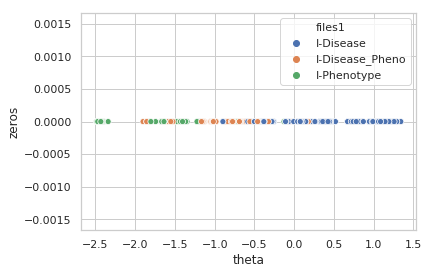

In [286]:
plot_thetas(pos, annotator_names[0])

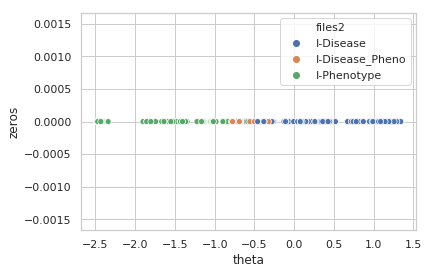

In [287]:
plot_thetas(pos, annotator_names[1])

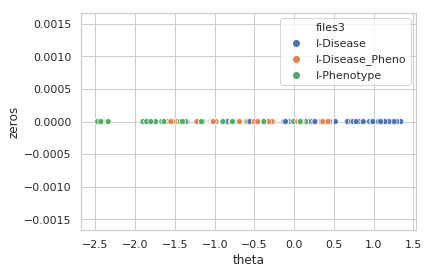

In [288]:
plot_thetas(pos, annotator_names[2])

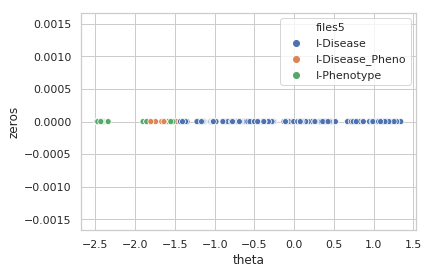

In [289]:
plot_thetas(pos, annotator_names[4])

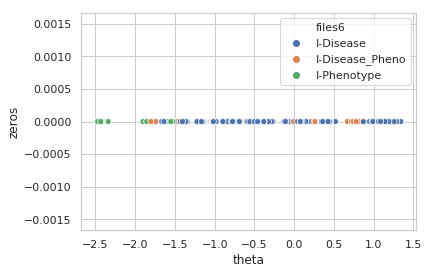

In [290]:
plot_thetas(pos, annotator_names[5])

In [291]:
xda, xdr = get_annotator_bias(avg_values['d_alpha'], avg_values['d_beta'])

In [292]:
xpa, xpr = get_annotator_bias(avg_values['p_alpha'], avg_values['p_beta'])

In [293]:
xda - xdr

array([0.73244115, 1.52463818, 0.56835607, 1.18354754, 0.40446907,
       0.54645057])

In [294]:
xpa - xpr

array([-1.00159041, -1.15907572, -0.71600131, -0.69113113, -0.5523632 ,
       -0.21809377])

In [295]:
(xda + xdr)/2

array([-1.41019321, -0.72718904, -1.13240418, -0.49098148, -2.13132667,
       -1.93185289])

In [296]:
(xpa + xpr)/2

array([-0.54550633, -0.4919417 , -0.15771552,  0.25506944, -1.54238049,
       -2.16484216])

In [297]:
loc_pd = pd.DataFrame()
#loc_pd['Val'] = ["xda", "xdr", "xpa", "xpr"]
#
#for i in range(5):
#    loc_pd['Annotator{}'.format(i+1)] = [xda[i], xdr[i], xpa[i], xpr[i]]

#loc_pd.index = ["xda", "xdr", "xpa", "xpr"]
loc_pd['xda'] = xda
loc_pd['xdr'] = xdr
loc_pd['xpa'] = xpa
loc_pd['xpr'] = xpr
loc_pd['annotator'] = annotator_names
#ax = sns.scatterplot(x=0, y="zeros", data=dis_loc_pd)

In [298]:
loc_pd

,xda,xdr,xpa,xpr,annotator
0,-1.043973,-1.776414,-1.046302,-0.044711,files1
1,0.035130,-1.489508,-1.071480,0.087596,files2
2,-0.848226,-1.416582,-0.515716,0.200285,files3
3,0.100792,-1.082755,-0.090496,0.600635,files4
4,-1.929092,-2.333561,-1.818562,-1.266199,files5
5,-1.658628,-2.205078,-2.273889,-2.055795,files6


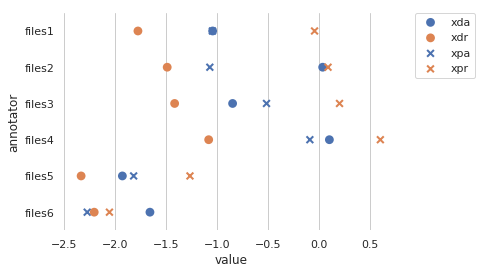

In [299]:
'''
loc_pd = pd.DataFrame()
#loc_pd['disease'] = (xda + xdr)/2
#loc_pd['phenotype'] = (xpa + xpr)/2
loc_pd['disease'] = xda
loc_pd['phenotype'] = xpa
loc_pd['annotator'] = ['Annotator{}'.format(i+1) for i in range(5)]
'''
dis_pd = pd.DataFrame()
dis_pd['xda'] = xda
dis_pd['xdr'] = xdr
dis_pd['annotator'] = annotator_names

phe_pd = pd.DataFrame()
phe_pd['xpa'] = xpa
phe_pd['xpr'] = xpr
phe_pd['annotator'] = annotator_names
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

#print(dis_pd)
#print
#print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1, ci=None)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1, ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [300]:
dis_loc = (xda + xdr)/2
phe_loc = (xpa + xpr)/2

phe_loc - dis_loc

array([ 0.86468688,  0.23524734,  0.97468866,  0.74605092,  0.58894618,
       -0.23298928])

[1.3652974  0.65589332 1.75946041 0.84491748 2.47237693 1.8299917 ]


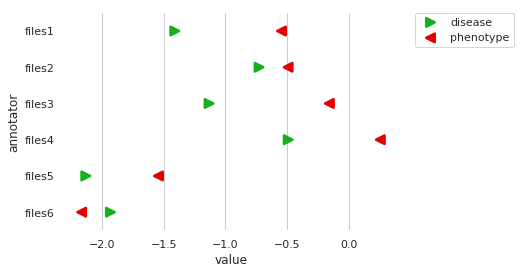

In [301]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc
dis_phe_pd['phenotype'] = phe_loc
dis_phe_pd['annotator'] = annotator_names

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

dis_phe_pd

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=[">", "<"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
#ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max), 0.5))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

dis_inverses = 1/(xda - xdr)
print(dis_inverses)

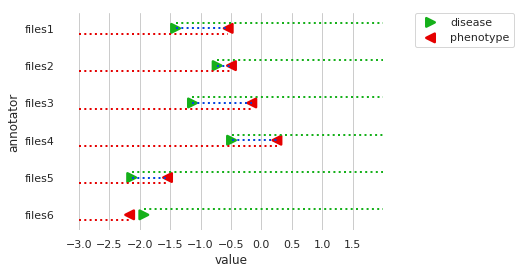

In [302]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc
dis_phe_pd['phenotype'] = phe_loc
dis_phe_pd['annotator'] = annotator_names

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

#print(dis_phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=[">", "<"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

i = 0
for annotator in annotator_names:
    #annotator = 'Annotator{}'.format(i+1)
    dis = dis_phe_pd[(dis_phe_pd['annotator'] == annotator) & (dis_phe_pd['measurement'] == 'disease')]['value']
    
    phe = dis_phe_pd[(dis_phe_pd['annotator'] == annotator) & (dis_phe_pd['measurement'] == 'phenotype')]['value']
    
    plt.plot([dis, np.ceil(theta_max)], [i-0.15, i-0.15], sns.xkcd_rgb["green"], lw=2, linestyle=':')
    plt.plot([np.floor(theta_min), phe], [i+0.15, i+0.15], sns.xkcd_rgb["red"], lw=2, linestyle=':')
    if dis.sum() < phe.sum():
        plt.plot([dis.sum(), phe.sum()], [i, i], sns.xkcd_rgb["blue"], lw=2, linestyle=':')
    i += 1

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max), 0.5))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


[Text(0,0,u'files1'),
 Text(0,0,u'files2'),
 Text(0,0,u'files3'),
 Text(0,0,u'files4'),
 Text(0,0,u'files5'),
 Text(0,0,u'files6')]

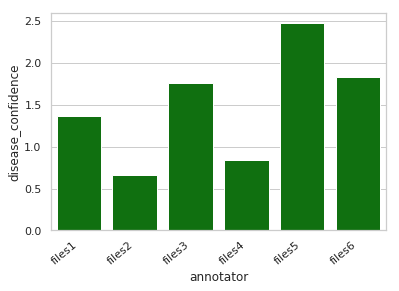

In [304]:
dis_inverses = 1/(xda - xdr)

dis_inverses_pd = pd.DataFrame()
dis_inverses_pd['disease_confidence'] = dis_inverses
dis_inverses_pd['annotator'] = annotator_names

ax = sns.barplot(x="annotator", y="disease_confidence", data=dis_inverses_pd, color="green")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

[Text(0,0,u'files1'),
 Text(0,0,u'files2'),
 Text(0,0,u'files3'),
 Text(0,0,u'files4'),
 Text(0,0,u'files5'),
 Text(0,0,u'files6')]

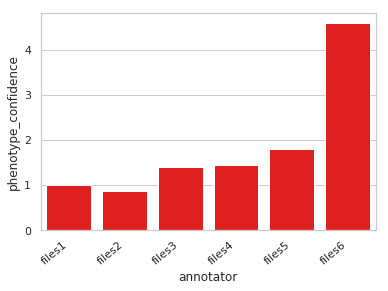

In [305]:
phe_inverses = 1/(xpr - xpa)

phe_inverses_pd = pd.DataFrame()
phe_inverses_pd['phenotype_confidence'] = phe_inverses
phe_inverses_pd['annotator'] = annotator_names

ax = sns.barplot(x="annotator", y="phenotype_confidence", data=phe_inverses_pd, color="red")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [306]:
def plot_theta_tokens(pos_annos):
    pos_theta = pos[['Token', 'theta']]
    pos_theta['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", data=pos_theta)

/home/akshita/anaconda3/envs/scripps/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


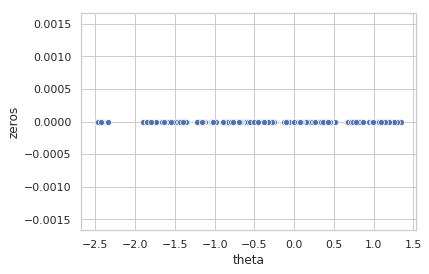

In [307]:
#pos[['Token', 'theta']]
plot_theta_tokens(pos)

In [308]:
def count_relevant_stats(relevant_annotations, annotator, label):
    return relevant_annotations[relevant_annotations[annotator] == label][annotator].count()

In [309]:
def get_relevant_stats(relevant_annotations, annotator):
    print 'Statistics for {}'.format(annotator)
    print 'Percentage of Disease labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Disease')/503.0)
    print 'Percentage of Phenotype labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Phenotype')/503.0)
    print 'Percentage of both labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Disease_Pheno')/503.0)

In [259]:
for annotator in annotator_names:
    get_relevant_stats(relevant_annotations, annotator)
    print

Statistics for files1
Percentage of Disease labels: 0.628230616302
Percentage of Phenotype labels: 0.105367793241
Percentage of both labels: 0.157057654076

Statistics for files2
Percentage of Disease labels: 0.62226640159
Percentage of Phenotype labels: 0.20675944334
Percentage of both labels: 0.0616302186879

Statistics for files3
Percentage of Disease labels: 0.500994035785
Percentage of Phenotype labels: 0.165009940358
Percentage of both labels: 0.224652087475

Statistics for files4
Percentage of Disease labels: 0.375745526839
Percentage of Phenotype labels: 0.268389662028
Percentage of both labels: 0.246520874751

Statistics for files5
Percentage of Disease labels: 0.789264413519
Percentage of Phenotype labels: 0.0715705765408
Percentage of both labels: 0.0298210735586

Statistics for files6
Percentage of Disease labels: 0.729622266402
Percentage of Phenotype labels: 0.065606361829
Percentage of both labels: 0.0954274353877

Statistics for NER_expert
Percentage of Disease labels: 